### Prepping for the Final Project

Jupyter notebook for practicing with graph data science.

Some of the code used at the start of this notebook is patterned after chapter 2 in
    Graph Data Science with Neo4j
    Estelle Scifo, Packt Publishing Ltd, 2023

Mike Goodrich
Brigham Young University

March 2024

---

Here's my version of a process for doing graph data science.
![A process for graph data science](figures/GraphDataScience.png)

The data was gathered by scraping the CS 236 Discord channel from Fall 2023. Note that all of Discord's bylaws were followed, so using the data is in compliance with Discord's policies. The data was cleaned and anonymized. (If you find a reference to a name, please let me know.)

The next step is to create a graph schema. We'll need to famililarize ourselves with the data to understand it. We'll use pandas data structures to hold the data. You don't have to know much about pandas to make this work. Let's read the data from the nodes.csv file.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
nodes_data = pd.read_csv('cs236_data/nodes.csv')
nodes_data.head() # This shows the first few entries in from the csv file

,node,type,value
0,530,person,TA
1,0,person,TA
2,80,person,Student
3,531,person,Student
4,162,person,Student


Each node is assigned a type, which you can see by looking at the header of the csv file. We can access the handful of nodes to see what their types are.

In [2]:
print(nodes_data['type'][306:317])

306    channel
307     person
308     person
309     person
310     person
311     person
312     thread
313     thread
314     thread
315     thread
316     thread
Name: type, dtype: object


We can see the unique types, and count the number of instances for each type.

In [3]:
nodes_data.value_counts('type')

type
thread     342
person     315
channel     14
Name: count, dtype: int64

This tells me that I have three types of nodes: thread, person, and channel. This indicates that I have the three node types in the graph schema.
![Three types of nodes](figures/node_types.png)


The data also has edge types. Let's read in the edge data and get familiar with it.

In [4]:
edges_data = pd.read_csv('cs236_data/edges.csv')
edges_data.head()

,source,target,edge_type,content
0,0,1,posted_in_channel,Project Submission Question
1,0,0,replied_to,I'm feeling better so I'll be in at around 11:30
2,0,2,replied_to,Nope
3,0,3,replied_to,Will there be any TAs today?
4,0,4,replied_to,"Yes, see the <#1148663286267641906> for specif..."


What are the unique edge types?

In [5]:
edges_data.value_counts('edge_type')

edge_type
posted_in_thread     651
posted_in_channel    572
thread_in_channel    342
replied_to           294
Name: count, dtype: int64

Not all edge types can exist between each node type. The graph schema indicates with node types begin with each edge type.
![Graph schema with edges and nodes](figures/graph_schema.png)

---

Let's put this into a networkx graph by reading each edge. Notice that edges are found in edges.csv by looking at the source and target columns.

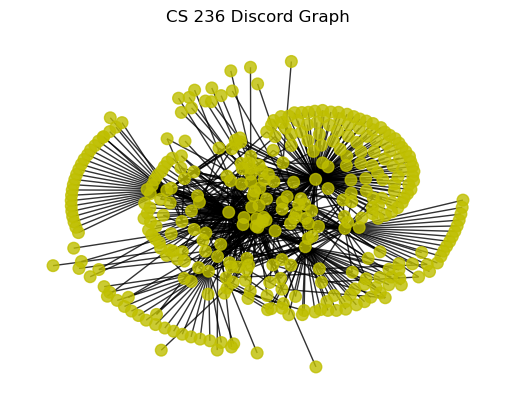

In [6]:
import networkx as nx
from graph_manager import graphHandler
G = nx.Graph()
for i in nodes_data.index:
    source = edges_data['source'][i]
    target = edges_data['target'][i]
    if source != target: # Don't include self loops
        G.add_edge(source, target)
class_manager = graphHandler(G, ['y' for node in G.nodes], use_pydot=True)
class_manager.showGraph(title="CS 236 Discord Graph")


Let's throw a handful of network analysis visualizations against this and see what we learn.

In [7]:
# Takes a minute or two to run
# class_manager.showDendrogram()

Since creating the dendrogram is slow, I'll just show the plot here.
![Dendrogram of Discord data](figures/dendrogram_of_discord_graph.png)

The Louvain algorithm found 11 partitions.
Partition 0 is {64, 261, 70, 71, 200, 266, 88, 91, 93, 288, 97, 33, 99, 58, 289, 290, 291, 292, 170, 172, 247, 248, 249, 250, 61}
Partition 1 is {0, 2, 5, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 30, 31, 35, 36, 37, 38, 39, 40, 41, 43, 46, 49, 51, 52, 53, 55, 56, 57, 67, 68, 74, 75, 76, 77, 82, 85, 87, 89, 90, 92, 103, 104, 107, 108, 109, 112, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 138, 139, 140, 141, 142, 146, 147, 148, 150, 151, 152, 153, 154}
Partition 2 is {1, 65, 4, 7, 137, 9, 78, 210, 279, 348, 285, 286, 349, 287, 162, 163, 164, 165, 34, 166, 168, 167, 102, 174, 175, 47, 177, 178, 176, 253, 319}
Partition 3 is {257, 187, 272, 273, 274, 48, 252, 181, 182, 188, 189, 26, 251, 60, 29}
Partition 4 is {322, 323, 324, 135, 136, 145, 275, 276, 149, 277, 278, 280, 281, 282, 157, 95, 293, 105, 106, 171, 173, 110, 111, 242, 179, 180, 246, 183, 184, 185}
Partition 5 is {130, 331, 6, 8, 10

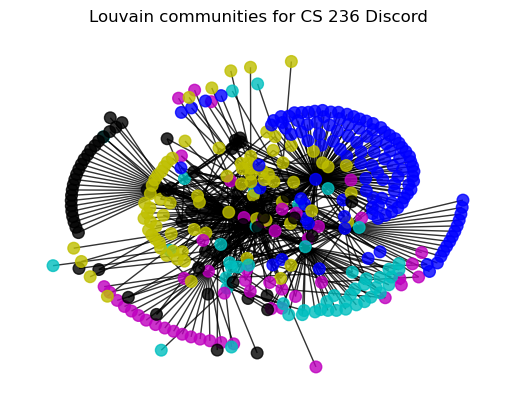

In [8]:
class_manager.showLouvainCommunities(title = "Louvain communities for CS 236 Discord")

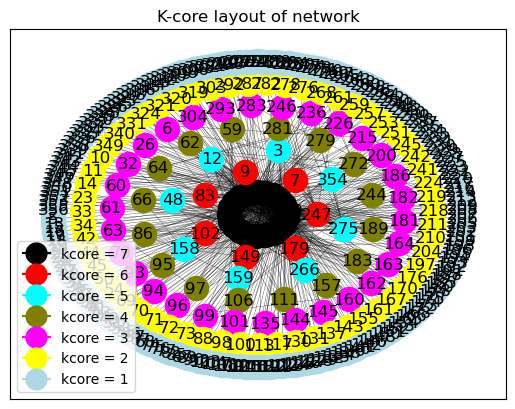

In [9]:
class_manager.show_kCores()

I'd like to see what the communities look like if I try to find them using the spectrum of the normalized graph Laplacian, $D^{-\frac{1}{2}}LD^{-\frac{1}{2}}$

[0, 4]


/Users/mymac/575/homework10_discord_data/utilities.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  z[i,0] = vector1[i]
/Users/mymac/575/homework10_discord_data/utilities.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  z[i,1] = vector2[i]


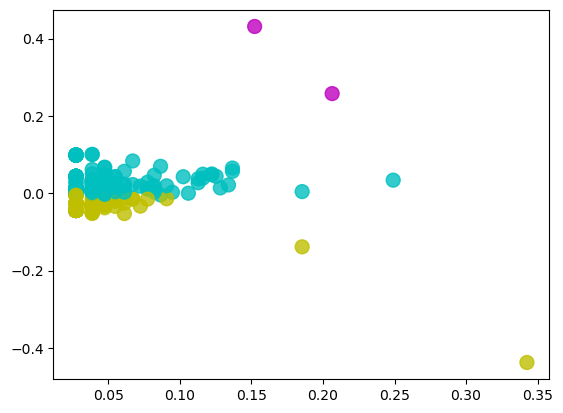

In [10]:
from utilities import get_two_fiedler_eigenvectors
from utilities import form_encoding
from utilities import get_colors_from_clusters
import matplotlib.pyplot as plt
L = nx.linalg.normalized_laplacian_matrix(class_manager.getGraph()).toarray()
v1,v2 = get_two_fiedler_eigenvectors(L)
embedding = form_encoding(v1, v2)
colors = get_colors_from_clusters(embedding, num_clusters=3)
plt.scatter(embedding[:,0], embedding[:,1],s=100,alpha = 0.8, color = colors);

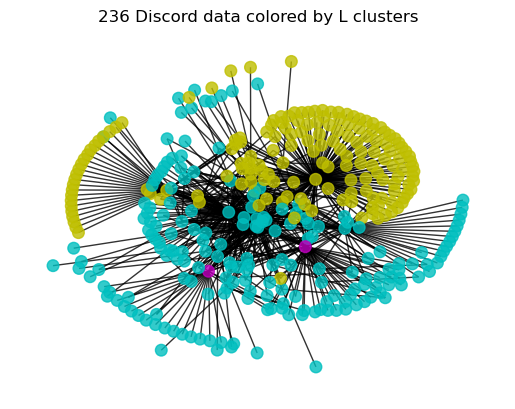

In [11]:
class_manager.showGraph(title = "236 Discord data colored by L clusters",agent_colors=colors)

Let's see what the graph structure looks like if we try to find clusters in the spectrum of the adjacency matrix.

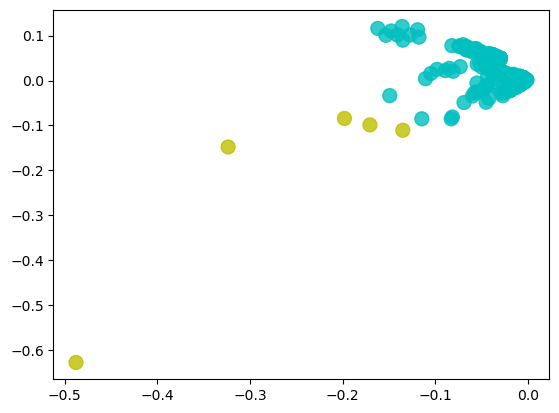

In [12]:
from utilities import get_largest_vectors
A = nx.linalg.adjacency_matrix(class_manager.getGraph()).toarray()
v1,v2 = get_largest_vectors(A)
embedding = form_encoding(v1, v2)
colors = get_colors_from_clusters(embedding, num_clusters=2)
plt.scatter(embedding[:,0], embedding[:,1],s=100,alpha = 0.8, color = colors);

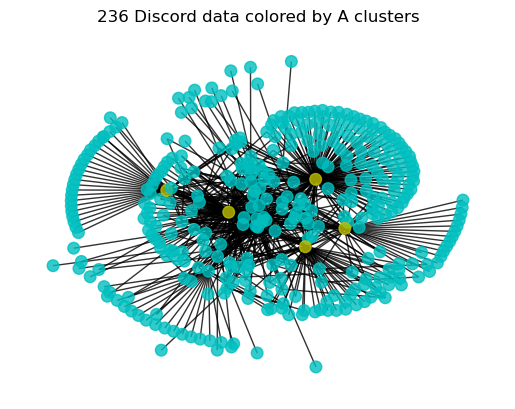

In [13]:
class_manager.showGraph(title = "236 Discord data colored by A clusters",agent_colors=colors)

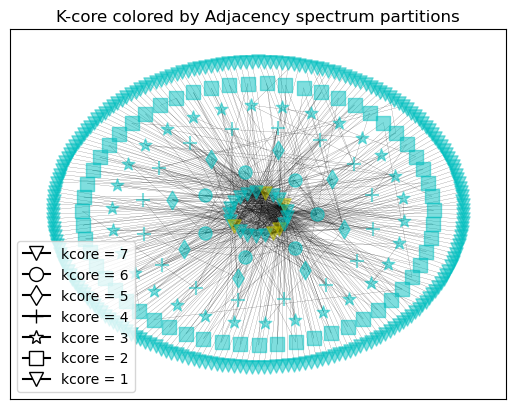

In [14]:
class_manager.show_kCores_by_partition(colors, title="K-core colored by Adjacency spectrum partitions")

---

We've built a graph, but the graph doesn't have any information about node types an edge types. 

Let's enrich what is in the node data stored in the graph. Let's add node types as node attributes, and edge_types as edge attributes.

In [15]:
node_type_dict = {nodes_data['node'][i]: 
                  nodes_data['type'][i] for i in nodes_data.index}
nx.set_node_attributes(G, node_type_dict, "node_type")
for node in {0,1,15,16}: print(node,G.nodes[node]['node_type'])

0 person
1 channel
16 thread
15 thread


In [16]:
import numpy as np
edge_type_dict = {(edges_data['source'][i], edges_data['target'][i])
                   : edges_data['edge_type'][i] for i in edges_data.index}
edge_type = [(u,v,edge_type_dict[(u,v)]) for (u,v) in edge_type_dict.keys()]
nx.set_edge_attributes(G, edge_type_dict, "edge_type")
random_edges = np.random.choice(list(range(len(G.edges))),5)
for i in random_edges:
    edge = list(G.edges)[i]
    print(f"edge = {edge} is of type {G.edges[edge[0],edge[1]]['edge_type']}")

edge = (8, 86) is of type posted_in_thread
edge = (84, 266) is of type replied_to
edge = (84, 258) is of type replied_to
edge = (81, 351) is of type replied_to
edge = (7, 168) is of type posted_in_thread


Color the nodes in the graph by their type

{'person': 'y', 'channel': 'm', 'thread': 'c'}


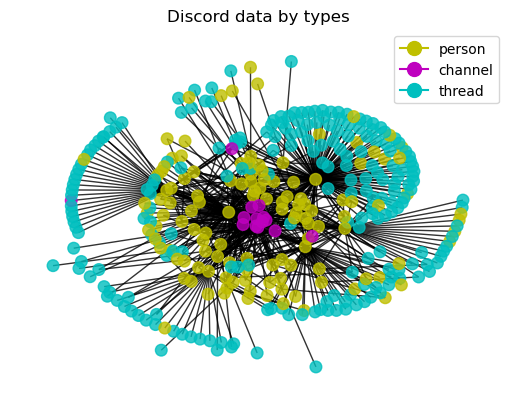

In [17]:
from matplotlib.lines import Line2D
colors = []
H = class_manager.getGraph() # Get graph sorted by value
color_map = ['y', 'm', 'c', 'b', 'g', 'k']
types = list(set(node_type_dict.values()))
type_colors = {types[i]: color_map[i%len(color_map)] for i in range(len(types))}
print(type_colors)
legend_elements = []
for node_type in type_colors.keys():
    legend_elements.append(Line2D([0], [0], marker='o', color=type_colors[node_type], markerfacecolor = type_colors[node_type], label=node_type, markersize=10))
for node in H.nodes:
    #print(node, G.nodes[node]['node_type'])
    colors.append(type_colors[G.nodes[node]['node_type']])
class_manager.showGraph(title="Discord data by types", agent_colors=colors, legend=legend_elements)

---

Let's define a new ontology element. We'll say that two persons interacted with each other if 
 - one person replied to the other, or
 - both persons posted in the same thread
Let's see if we can construct this.

If it were a database, we'd have the following relations:
 - replied_to(person1, person2)
 - posted_in_thread(person, thread)
 - posted_in_channel(person, channel)
 - thread_in_channel(thread, channel)
We'll be ignoring channels, but we won't know how to do that for a minute.

Our rule is that two persons interacted with each other if they satisfy one of two conditions: replied or posted in same thread. This is written using relational operators as
 - interacted_with(person1, person2) $\leftarrow$ replied_to(person1, person2)
 - interacted_with(person1, person2) $\leftarrow$ interacted_with(person2, person1)
 - interacted_with(person1, person2) $\leftarrow$ posted_in_thread(person1, thread) $\wedge$ posted_in_thread(person2, thread)
 
Our query is then _interacted_with(person1, person2)_, which can be implemented using relational algebra.

When we use a knowledge graph, we try to implement queries like this using _graph projections_. Let's explore the first thing we did: ignore channels. This is implemented by projecting the current graph onto a new one without the channels.

Your goal is to create something that looks a lot like the following figure

![who is important for interactions](figures/who_is_important_when_interacting.png)


You'll do this using the following steps:
 - Use as many of the four projection types as you need to for the network of who interacts with whom.
   - Two persons interact if one replies to another.
   - Two persons interact if both post to the same thread.
 - Show the graph of who interacts with whom.
 - Find which nodes are important using the spectrum of the adjacency matrix as illustrated in the Jupyter notebook tutorial for the lecture on March 12. The steps include 
   - Find the adjacency matrix of the graph from the previous step.
   - Find the eigenvectors for the principal eigenvalue and eigenvalue with second highest magnitude.
   - Define the embedding of each node as the 2D vector of the node from these eigenvectors. 
   - Cluster the embedding into three clusters using the algorithm from the Jupyter notebook
   - Color the nodes in the network according to their cluster

I'll get you started by projecting out nodes with type "channel".

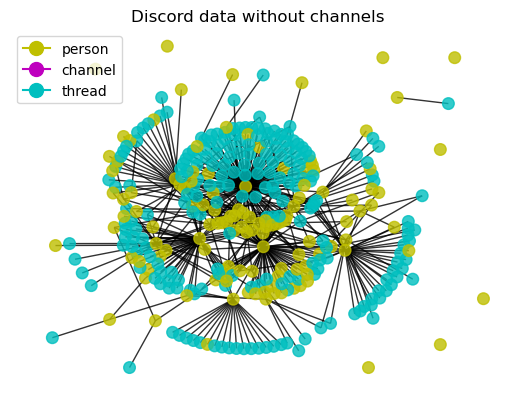

In [18]:
G.remove_nodes_from([node for node in G.nodes if G.nodes[node]['node_type'] == 'channel'])
projected_graph_manager = graphHandler(G, colormap=['y' for node in G.nodes], use_pydot=True)
colors = []
for node in G.nodes:
    colors.append(type_colors[G.nodes[node]['node_type']])
projected_graph_manager.showGraph(title="Discord data without channels", agent_colors=colors, legend=legend_elements)

We should only have edges we care about ("replied to" and "posted in thread"), but let's double check to be safe

In [19]:
set(nx.get_edge_attributes(G, 'edge_type').values())

{'posted_in_thread', 'replied_to'}

This means that we don't need to worry about type-2 projections (removing edges we don't care about)

Projection type 3: remove singletons

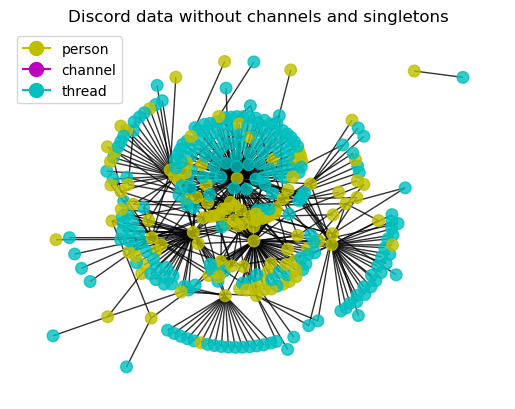

In [20]:
G.remove_nodes_from([node for node in G.nodes if nx.degree(G, node) < 1])
projected_graph_manager = graphHandler(G, colormap=['y' for node in G.nodes], use_pydot=True)
colors = []
for node in G.nodes:
    colors.append(type_colors[G.nodes[node]['node_type']])
projected_graph_manager.showGraph(title="Discord data without channels and singletons", agent_colors=colors, legend=legend_elements)

Projection type 4: add new relation

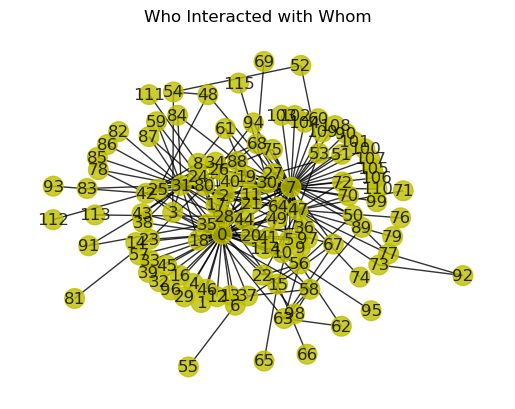

In [21]:
# Create bi-partite graph by removing "replied to" edges
replied_to_edges = []  # We'll need to add these back at the end

for u, v, attrs in list(G.edges(data=True)):
    if 'edge_type' in attrs and attrs['edge_type'] == 'replied_to':
        G.remove_edge(u, v)
        replied_to_edges.append((u, v))

# Calculate the two-step paths matrix
A = nx.adjacency_matrix(G).toarray()
two_step_paths = A @ A

# Remove self-loops
np.fill_diagonal(two_step_paths, 0)

# Add edges between nodes based on the two-step path matrix
nodes = list(G.nodes())

for i in range(len(two_step_paths)):
    for j in range(len(two_step_paths[0])):
        node_1, node_2 = nodes[i], nodes[j]

        if two_step_paths[i][j] > 0:
            G.add_edge(node_1, node_2)

# Add back the "replied to" edges
G.add_edges_from(replied_to_edges)

# Remove any thread nodes and singletons
G.remove_nodes_from([node for node in G.nodes if G.nodes[node]['node_type'] == 'thread'])
G.remove_nodes_from([node for node in G.nodes if nx.degree(G, node) < 1])

projected_graph_manager = graphHandler(G, colormap=['y' for _ in G.nodes], use_pydot=True)
projected_graph_manager.showGraph(title="Who Interacted with Whom", agent_colors=['y'] * G.number_of_nodes(), with_labels=True)

We should be ready to find communities.  However, as a safety check, let's ensure that every node is a person and has degree of at least 1

In [22]:
for node in G.nodes():
    assert G.nodes[node]['node_type'] == 'person' and nx.degree(G, node) >= 1

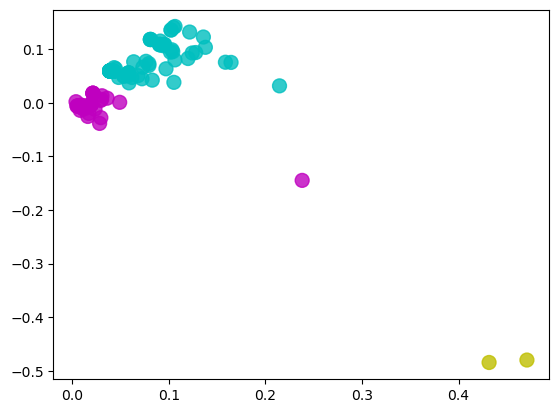

In [23]:
A = nx.adjacency_matrix(G).toarray()
v1, v2 = get_largest_vectors(A)
embedding = form_encoding(v1, v2)
colors = get_colors_from_clusters(embedding, num_clusters=3)
plt.scatter(embedding[:,0], embedding[:,1],s=100,alpha = 0.8, color = colors);

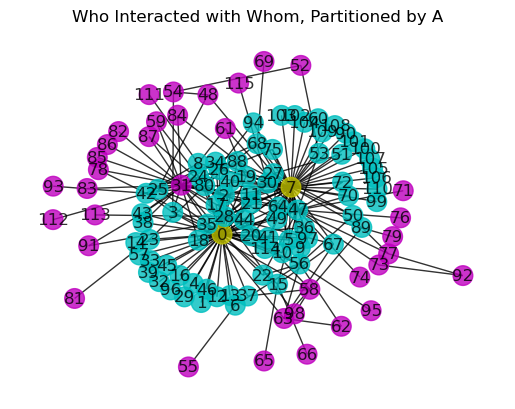

In [24]:
projected_graph_manager.showGraph(title = "Who Interacted with Whom, Partitioned by A", agent_colors=colors, with_labels=True)